Preprocess image data for classification with TensorFlow CNNs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
lambda_eff = {
    'UVW2':2085.73,
    'UVW1':2684.14,
    'UVM2':2245.78,
    'U':3751.,
    'B':4344.,
    'V':5456.,
    'R':6442.,
    'I':7994.,
    'J':12355.,
    'u':3546.,
    'g':4670.,
    'r':6156.,
    'i':7472.,
    'z':8917.,
    'y':10305.,
    'Y':10305.
}

lambda_1 = np.max(list(lambda_eff.values())) #12355. 

In [57]:
def plot_cmap(ax, X1, X2, Y, fs=13):

    cm = ax.pcolormesh(X1, X2*lambda_1, Y, shading='auto', cmap='inferno')
    ax.invert_yaxis()
    
    ax.set_xlabel('Time since first observation (days)', fontsize=fs)
    ax.set_ylabel('Wavelength ($\AA$)', fontsize=fs)
    
    fig.colorbar(cm, ax=ax)

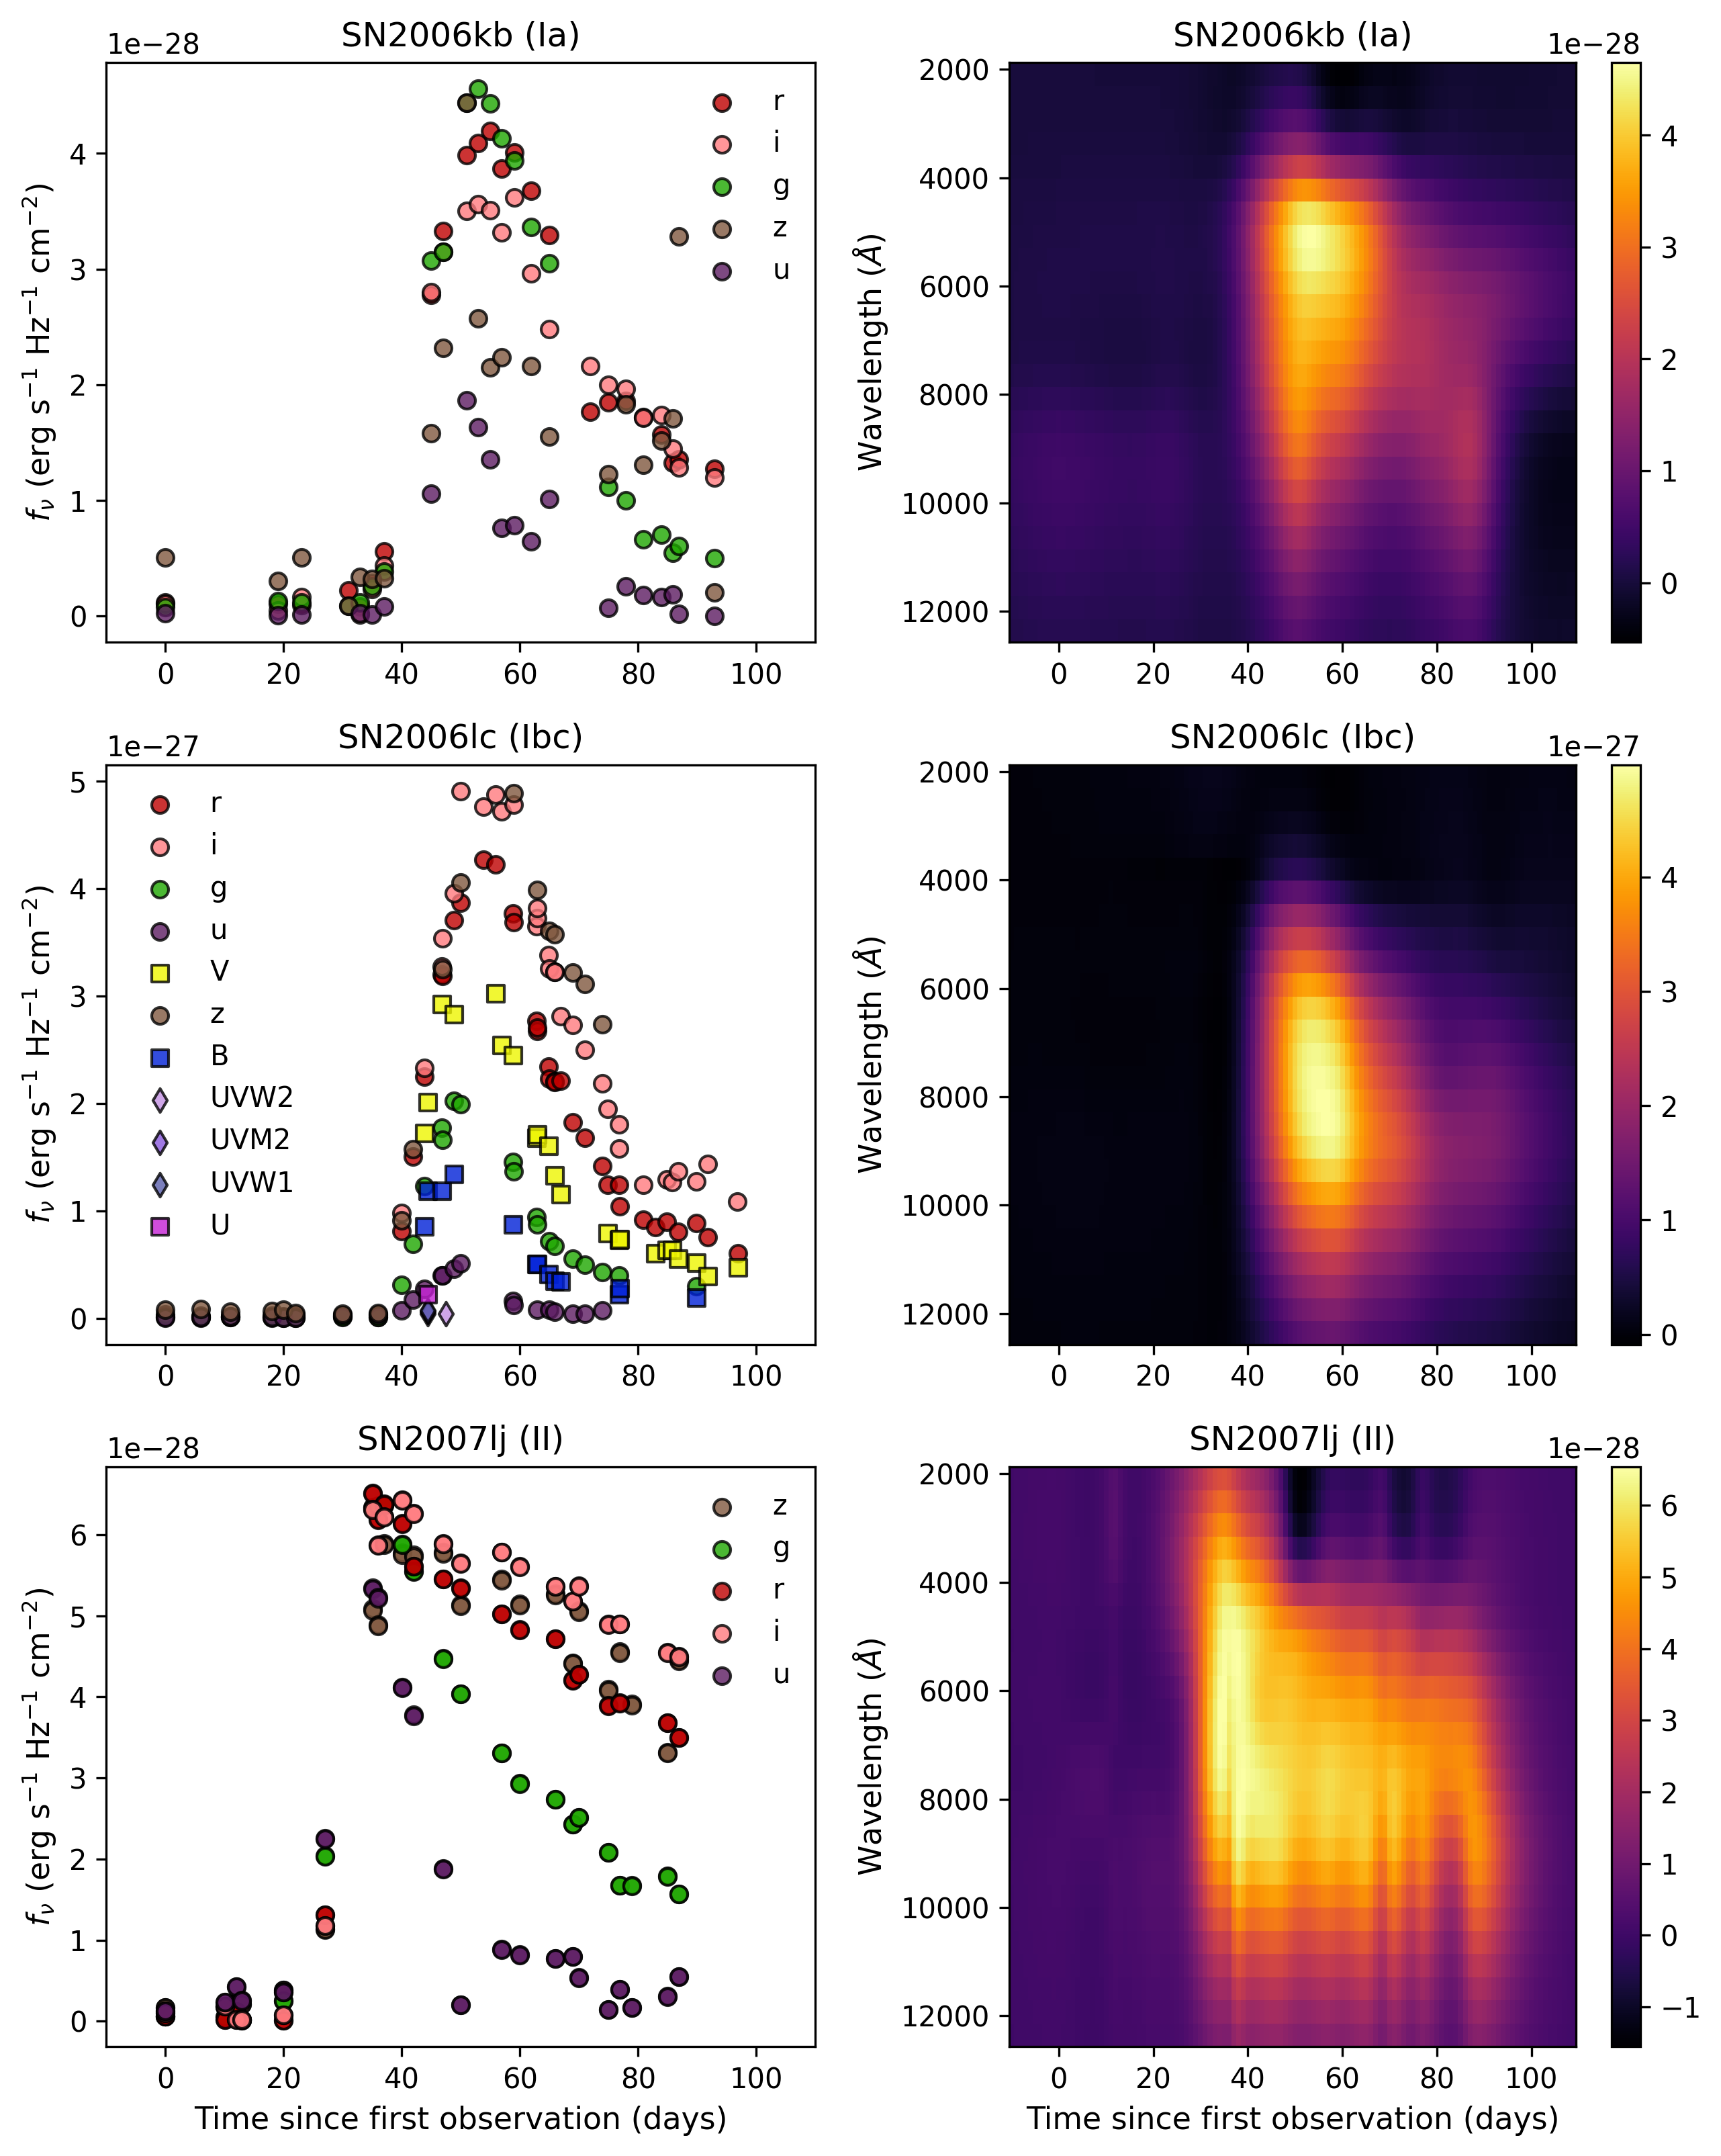

In [63]:
from IPython.display import Image

# Show example light curves and heatmaps
Image(filename='2d_gp_examples.png', width=650) 

In [3]:
# Load metadata
train_metadata = pd.read_csv('metadata/train_metadata.csv')
val_metadata = pd.read_csv('metadata/validation_metadata.csv')
test_metadata = pd.read_csv('metadata/test_metadata.csv')

In [13]:
pd.options.display.max_columns = 50 # Set maximum visible columns
display(train_metadata.iloc[[0]])

,name,type,n_types,spectra,discover_date,discovering_group,comoving_distance,comoving_distance_unit,ra,ra_unit,dec,dec_unit,ebv,ebv_err,host_galaxy,luminosity_distance,luminosity_distance_unit,redshift,grade,photometry,filters,avg_obs_per_filter,length,grouped_type
0,SN2010kg,Ia,1,True,2010/11/29,LOSS,73.322,Mpc,04:40:08.40,hours,+07:21:00.0,degrees,0.1307,0.0022,NGC 1633,74.542,Mpc,0.016632,g1,130.0,9.0,14.444444,85.95,Ia


In [40]:
# Load an example heatmap
example_sn = 'SN2010kg'
sn_heatmap_file = np.load('heatmap_data/trainset/{}.npy'.format(example_sn), allow_pickle=True)
display(sn_heatmap_file)

array({'flux_grid': array([[-7.94071829e-30, -1.27349177e-29, -1.83733119e-29, ...,
         1.04330403e-30,  9.61619971e-31,  8.86247187e-31],
       [-1.47909485e-28, -1.46470269e-28, -1.43403625e-28, ...,
         1.05829729e-30,  9.74300176e-31,  8.96903865e-31],
       [-4.57730787e-28, -4.51480147e-28, -4.39849568e-28, ...,
        -2.35299188e-31, -2.22535618e-31, -2.10207747e-31],
       ...,
       [-1.67444389e-27, -1.53974601e-27, -1.36398201e-27, ...,
         6.30824154e-29,  5.80121304e-29,  5.33463739e-29],
       [-1.72639795e-27, -1.58138200e-27, -1.39285185e-27, ...,
         6.70822234e-29,  6.16849939e-29,  5.67188949e-29],
       [-1.72305000e-27, -1.57405523e-27, -1.38081599e-27, ...,
         6.83574742e-29,  6.28539589e-29,  5.77904129e-29]]), 'time': array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  

In [44]:
# Get heatmap values
heatmap = sn_heatmap_file.item().get('flux_grid')
time = sn_heatmap_file.item().get('time')
wavelength = sn_heatmap_file.item().get('wavelength')
display(heatmap)

array([[-7.94071829e-30, -1.27349177e-29, -1.83733119e-29, ...,
         1.04330403e-30,  9.61619971e-31,  8.86247187e-31],
       [-1.47909485e-28, -1.46470269e-28, -1.43403625e-28, ...,
         1.05829729e-30,  9.74300176e-31,  8.96903865e-31],
       [-4.57730787e-28, -4.51480147e-28, -4.39849568e-28, ...,
        -2.35299188e-31, -2.22535618e-31, -2.10207747e-31],
       ...,
       [-1.67444389e-27, -1.53974601e-27, -1.36398201e-27, ...,
         6.30824154e-29,  5.80121304e-29,  5.33463739e-29],
       [-1.72639795e-27, -1.58138200e-27, -1.39285185e-27, ...,
         6.70822234e-29,  6.16849939e-29,  5.67188949e-29],
       [-1.72305000e-27, -1.57405523e-27, -1.38081599e-27, ...,
         6.83574742e-29,  6.28539589e-29,  5.77904129e-29]])

In [68]:
np.max(heatmap)

2.008493602776148e-26

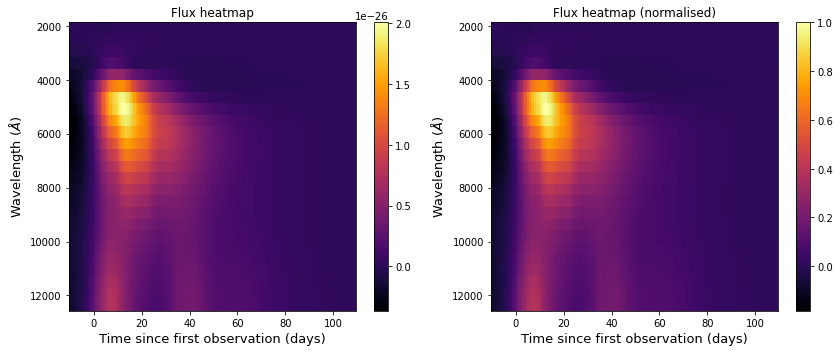

In [72]:
# Plot an example heatmap
fig, axs = plt.subplots(1, 2, figsize=(12,5))

plot_cmap(axs[0], time, wavelength, heatmap)
plot_cmap(axs[1], time, wavelength, heatmap/np.max(heatmap))

axs[0].set_title('Flux heatmap')
axs[1].set_title('Flux heatmap (normalised)')

plt.tight_layout()
plt.show()

We want to create pairs of input images $X$ and corresponding image labels $y$
- For each supernova, get the its spectroscopic type and heatmap data
- Create a image-label $(X,y)$ pair for each supernova

In [73]:
spec_type_code = {'Ia':0,
                  'Ibc':1,
                  'II':2}

In [74]:
# Define method to get SN metadata
def get_sn_metadata(df_row):
    
    sn_name = df_row['name']
    spec_type = df_row['grouped_type']
    spec_type_num = spec_type_code[spec_type]
    
    return sn_name, spec_type_num

In [78]:
name_type_pair = [get_sn_metadata(row) for i, row in train_metadata.iterrows()]
display(name_type_pair[:10])

[('SN2010kg', 0),
 ('SN2008Q', 0),
 ('SDSS-II SN 19699', 2),
 ('SDSS-II SN 19573', 0),
 ('PSc150570', 0),
 ('SDSS-II SN 13815', 2),
 ('SDSS-II SN 4509', 2),
 ('SDSS-II SN 1825', 0),
 ('SN2006jz', 0),
 ('ASASSN-15mf', 0)]

In [79]:
# Define method to get heatmap values
def get_sn_heatmap(sn_name, data_dir, norm=True):
        
    # Get heatmap from data file
    sn_file = np.load('{}/{}.npy'.format(data_dir, sn_name), allow_pickle=True)
    heatmap = sn_file.item().get('flux_grid')
    
    # Normalise heatmap
    if norm==True:
        heatmap = heatmap/np.max(heatmap)
    
    return heatmap

In [83]:
hm = get_sn_heatmap(sn_name = 'SN2010kg', data_dir='heatmap_data/trainset')
display(hm)

array([[-3.95356912e-04, -6.34053186e-04, -9.14780701e-04, ...,
         5.19446030e-05,  4.78776716e-05,  4.41249694e-05],
       [-7.36419995e-03, -7.29254345e-03, -7.13985967e-03, ...,
         5.26910960e-05,  4.85090007e-05,  4.46555500e-05],
       [-2.27897558e-02, -2.24785454e-02, -2.18994757e-02, ...,
        -1.17152073e-05, -1.10797275e-05, -1.04659406e-05],
       ...,
       [-8.33681464e-02, -7.66617334e-02, -6.79106973e-02, ...,
         3.14078249e-03,  2.88834031e-03,  2.65603902e-03],
       [-8.59548641e-02, -7.87347293e-02, -6.93480849e-02, ...,
         3.33992716e-03,  3.07120689e-03,  2.82395198e-03],
       [-8.57881746e-02, -7.83699399e-02, -6.87488371e-02, ...,
         3.40342006e-03,  3.12940797e-03,  2.87730132e-03]])

In [88]:
def create_xy(df, data_dir):
    
    X = []
    y = []
    for i, row in df.iterrows():
        sn_name, sn_type = get_sn_metadata(row)
        
        # If heatmap file doesn't exist, skip
        try:
            heatmap = get_sn_heatmap(sn_name, data_dir)
        except FileNotFoundError:
            continue
            
        X.append(heatmap)
        y.append(sn_type)
    
    return np.array(X), np.array(y)

In [94]:
X_train, y_train = create_xy(train_metadata, 'heatmap_data/trainset')
print(X_train.shape, y_train.shape)

(3796, 25, 120) (3796,)
